# TP Programmation avec Keras - Cas MNIST, fonctionnalités avancées

Nous allons produire un réseau de neurones pour effectuer une classification sur le cas MNIST avec les bibliothèques keras/tensorflow. MNIST est une base de données composée d'images de chiffres. Nous allons mettre en place ici des fonctionnalités un peu plus avancées, liées à la régularisation, batchnormalisation, au jeu de validation, early stopping...

Dans ce TP, des cellules seront laissées à trous, il faudra les compléter suivant les consignes. Elles seront identifiées par le mot **Exercice**. Les **Vérifications** seront effectuées principalement par vous-mêmes, sur la bonne convergence des algorithmes ou leur bon fonctionnement.

Ci-dessous, on importe les bibliothèques qui seront utiles.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

## Mise en place des données

Le code ci-dessous charge les données MNIST.

In [3]:
#NE PAS MODIFIER

(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

**Exercice** : Normalisez les données d'entrées en les divisant par 255 et passez les données de sortie sous forme catégorielle (one hot encoding, en utilisant keras.utils.to_categorical)

In [4]:
X_train = X_train/255

X_test = X_test/255

Y_train_cat = keras.utils.to_categorical(Y_train,num_classes = 10)

Y_test_cat = keras.utils.to_categorical(Y_test,num_classes = 10)

## Modèle Keras

### Création du modèle avec régularisation

**Exercice** : Créez un modèle avec Keras que vous appellerez "my_model".

**Instructions spécifiques** : 
- La première couche doit être Flatten en mettant le bon input_shape
- Faites attention à la dernière couche (nombre de neurones, fonction d'activation)
- Placez entre chaque couche une couche de batchnormalization : keras.layers.Batchnormalization. Pas besoin de mettre d'argument. Ne pas utiliser cette couche en sortie.
- Placez après chaque batchnormalization une couche de Dropout : keras.layers.Dropout. Il faut mettre en argument le taux de dropout (entre 0 et 1). Essayez quelque chose de l'ordre de 0.2. Ne pas utiliser ce type de couche en sortie.
- Dans chaque couche Dense, mettez une régularisation. Utilisez les mot-clés kernel_regularizer et bias_regularizer dans les couches Dense. Donnez leur ensuite les variables keras.regularizers.l2(1e-3). 1e-3 correspond au paramètre de régularisation.

In [39]:
my_model = keras.Sequential()
my_model.add(keras.layers.Flatten(input_shape = (28,28,)))
my_model.add(keras.layers.Dense(128,activation = "relu",kernel_regularizer = keras.regularizers.l2(1e-4)))
my_model.add(keras.layers.BatchNormalization())
my_model.add(keras.layers.Dropout(0.1))

my_model.add(keras.layers.Dense(128,activation = "relu",kernel_regularizer = keras.regularizers.l2(1e-4)))
my_model.add(keras.layers.BatchNormalization())
my_model.add(keras.layers.Dropout(0.1))

my_model.add(keras.layers.Dense(10,activation = "softmax"))

**Exercice** : Affichez la structure de votre modèle avec my_model.summary()

In [40]:
my_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               100480    
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512       
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)              

**Vérification** : Pour l'instant, il suffit qu'il n'y ait pas d'erreur.

### Compilation du modèle

**Exercice** : Compilez le modèle avec l'optimizer que vous souhaitez. Mettez une loss function adaptée ainsi qu'une métrique adaptée.

In [41]:
opt = keras.optimizers.Adam(lr = 0.01)
my_model.compile(optimizer = opt, loss = "categorical_crossentropy",metrics = ["categorical_accuracy"])

**Vérification** : De nouveau, s'il n'y a pas d'erreur et que vous avez suivi les instructions, tout devrait bien se passer.

### Mise en place de l'early stopping

**Exercice** : Nous allons utiliser un jeu de validation lors de l'apprentissage, que vous programmerez par la suite dans my_model.fit. Nous mettrons en place un early stopping sur ce jeu de validation qui arrêtera l'apprentissage lorsque la fonction de coût sur ce jeu de validation ne décroît plus après un certain nombre d'époques.

Pour ce faire :
- Mettez dans cette variable un keras.callbacks.EarlyStopping(...)
- Il faut dire ce qui est surveillé pour cet early stopping. Nous allons utiliser la loss de validation. Pour ce faire, utilisez le mot-clé monitor et affectez-lui la chaîne de caractères "val_loss"
- Il faut dire pendant combien d'époques d'affilée on surveille si la fonction de coût de validation ne diminue plus. Pour ce faire, utilisez le mot-clé patience et affectez-lui le nombre d'époques que vous souhaitez surveiller. Dans notre cas, une dizaine d'époques devrait suffire.
- Enfin, il faut préciser au modèle qu'il doit restaurer les paramètres correspondant à la meilleure valeur de la fonction de coût. Cela se fait en utilisant le mot-clé restore_best_weights et lui affectant True.

In [42]:
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 10,restore_best_weights=True)

## L'apprentissage

**Exercice** : Il faut maintenant effectuer l'apprentissage. Stockez l'historique de votre entraînement dans une variable pour pouvoir ensuite afficher l'évolution de la fonction de coût et de l'accuracy.

**Instructions spécifiques** :
- Il faut préciser un jeu de validation. Cela peut se faire en utilisant le mot-clé validation_data et lui donnant un jeu de validation prédéfini sous la forme (X_val,Y_val), si vous avez un tel jeu de validation sous la main. On pourrait par exemple utiliser X_test et Y_test_cat par exemple. Cependant dans notre cas, nous allons conserver le jeu de test pour des tests finaux. L'autre possibilité est de scinder X_train et Y_train_cat en deux parties : une partie sera le jeu d'entraînement et l'autre partie sera conservée pour la validation. Pour ce faire, il faut utiliser le mot-clé validation_split et lui affecter la part des données que vous souhaitez utiliser pour la validation. Vous pouvez utilisez 0.1 par exemple, ce qui signifie que 10 % des données seront utilisées pour la validation.
- Il faut aussi préciser l'early stopping. Cela se fait en utilisant le mot-clé callbacks et en lui affectant une liste contenant la variable early_stopping. Il faut effectivement utiliser une liste car plusieurs callbacks peuvent être affectés.
- Enfin, utilisez aussi des mini-batchs. Pour ce faire, utilisez le mot-clé batch_size et indiquez la taille des mini-batchs. 128 pourrait faire l'affaire.

In [43]:
learning = my_model.fit(X_train,Y_train_cat,epochs = 100, batch_size = 128,validation_split = 0.1,callbacks = [early_stopping])

Epoch 1/100
422/422 [==============================] - 1s 3ms/step - loss: 0.3208 - categorical_accuracy: 0.9238 - val_loss: 0.2350 - val_categorical_accuracy: 0.9565
Epoch 2/100
422/422 [==============================] - 1s 3ms/step - loss: 0.2562 - categorical_accuracy: 0.9513 - val_loss: 0.2566 - val_categorical_accuracy: 0.9533
Epoch 3/100
422/422 [==============================] - 1s 3ms/step - loss: 0.2632 - categorical_accuracy: 0.9528 - val_loss: 0.2201 - val_categorical_accuracy: 0.9677
Epoch 4/100
422/422 [==============================] - 1s 3ms/step - loss: 0.2544 - categorical_accuracy: 0.9579 - val_loss: 0.2368 - val_categorical_accuracy: 0.9653
Epoch 5/100
422/422 [==============================] - 1s 3ms/step - loss: 0.2663 - categorical_accuracy: 0.9555 - val_loss: 0.2289 - val_categorical_accuracy: 0.9688
Epoch 6/100
422/422 [==============================] - 1s 3ms/step - loss: 0.2580 - categorical_accuracy: 0.9579 - val_loss: 0.2451 - val_categorical_accuracy: 0.963

**Vérification** : La loss function devrait diminuer et l'accuracy augmenter. De même pour le jeu de validation.

**Exercice** : Tracez l'évolution de la fonction de coût et de l'accuracy pour le jeu d'entraînement et pour le jeu de validation. Les clés à utiliser dans history sont "val_loss" et "val_categorical_accuracy".

Text(0.5, 1.0, 'Categorical accuracy evolution')

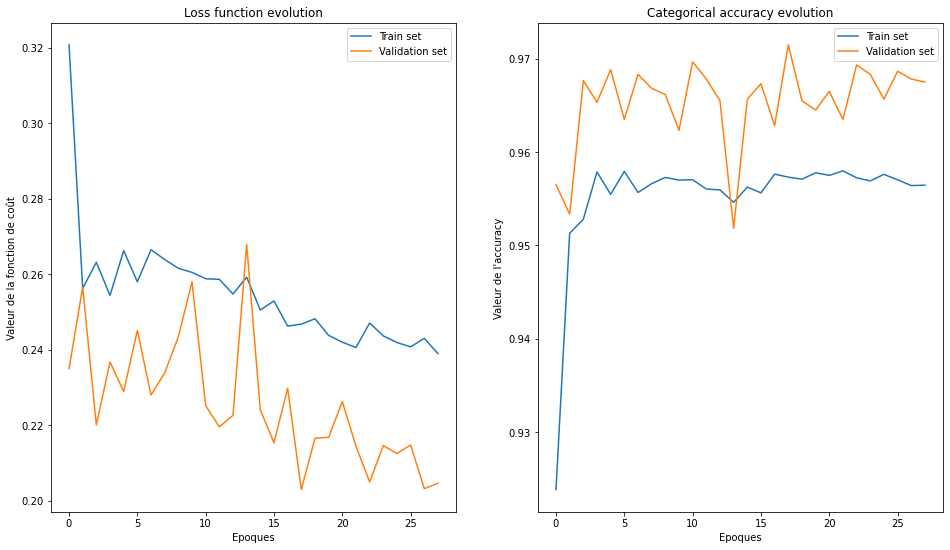

In [44]:
loss_evolution = learning.history["loss"]
acc_evolution = learning.history["categorical_accuracy"]
val_loss_evolution = learning.history["val_loss"]
val_acc_evolution = learning.history["val_categorical_accuracy"]


plt.figure(figsize = (16,9))
plt.subplot(121)
plt.plot(loss_evolution,label = "Train set")
plt.plot(val_loss_evolution,label = "Validation set")
plt.xlabel("Epoques")
plt.ylabel("Valeur de la fonction de coût")
plt.legend()
plt.title("Loss function evolution")

plt.subplot(122)
plt.plot(acc_evolution, label = "Train set")
plt.plot(val_acc_evolution, label = "Validation set")
plt.xlabel("Epoques")
plt.ylabel("Valeur de l'accuracy")
plt.legend()
plt.title("Categorical accuracy evolution")

## Prédictions avec le modèle

**Exercice** : Effectuez la prédiction sur le jeu de test.

In [45]:
Y_pred_test = my_model.predict(X_test)

**Exercice** : Extrayez les labels prédits par votre réseau, qui correspondent aux classes avec la plus grande probabilité. La fonction np.argmax vous sera utile, à appliquer sur le bon "axis".

In [46]:
Y_test_pred_lab = np.argmax(Y_pred_test,axis = 1)

**Exercice** : Calculez l'accuracy sur le jeu de test.

In [47]:
np.sum(Y_test_pred_lab == Y_test)/Y_test.shape[0]

0.967

Le code ci-dessous vous permet de visualiser quelques résultats pris au hasard sur la base de test.

Text(0, 0.5, 'Output du réseau')

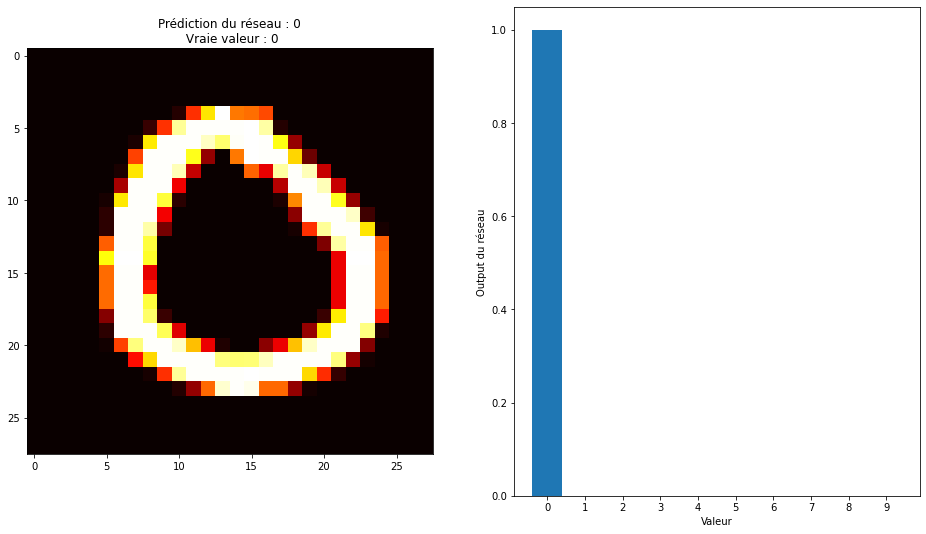

In [48]:
r = np.random.randint(X_test.shape[0])

figure = plt.figure(figsize = (16,9))

ax1 = plt.subplot(121)
ax1.imshow(X_test[r,:,:],cmap = "hot")
plt.title("Prédiction du réseau : " + str(Y_test_pred_lab[r]) + "\n Vraie valeur : " + str(Y_test[r]))

ax2 = plt.subplot(122)
ax2.bar(np.arange(10),height = Y_pred_test[r],tick_label = np.arange(10))
plt.xlabel("Valeur")
plt.ylabel("Output du réseau")


**Exercice** : Réutilisez le code d'affichage ci-dessus, mais pour afficher aléatoirement des erreurs. La fonction np.where vous sera utile pour localiser les erreurs.

Text(0, 0.5, 'Output du réseau')

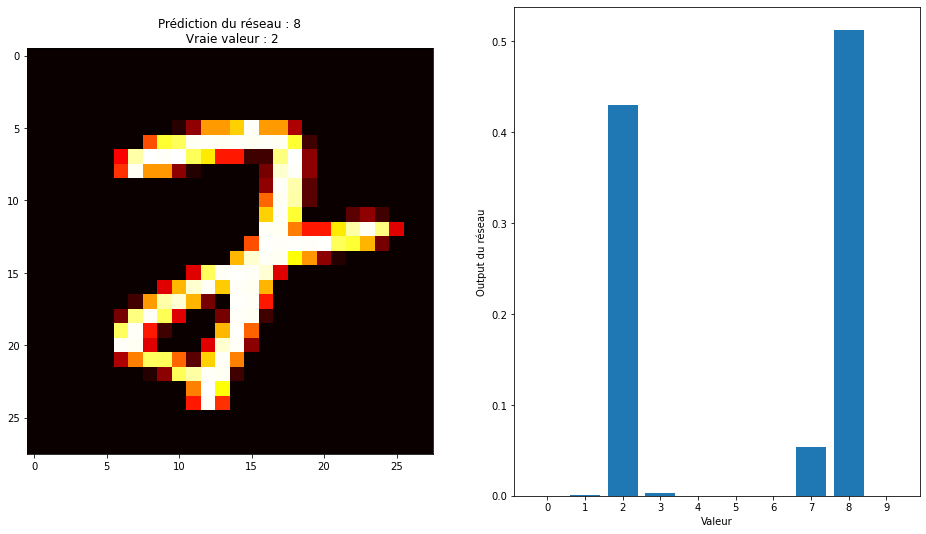

In [49]:
erreurs = np.where(Y_test_pred_lab != Y_test)[0]

r2 = np.random.randint(erreurs.shape[0])
r = erreurs[r2]

figure = plt.figure(figsize = (16,9))

ax1 = plt.subplot(121)
ax1.imshow(X_test[r,:,:],cmap = "hot")
plt.title("Prédiction du réseau : " + str(Y_test_pred_lab[r]) + "\n Vraie valeur : " + str(Y_test[r]))

ax2 = plt.subplot(122)
ax2.bar(np.arange(10),height = Y_pred_test[r],tick_label = np.arange(10))
plt.xlabel("Valeur")
plt.ylabel("Output du réseau")